In [38]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import sklearn
import matplotlib

'1.4.2'

'0.9.0'

'3.5.1'

'1.21.5'

'1.0.2'

In [2]:
######
###### Stage 1: Loading in Data 
######
######

In [3]:
#Read in the air pollution readingS for nox emissions at the Exeter Roadside AURN air pollution monitoring stations
#The details of the station itself can be found here: 
airPollutionTargetVector = pd.read_feather("AllDataset/airPollutionTargetVector/nox/Exeter Roadside.feather")
airPollutionTargetVector["Timestamp"] = pd.to_datetime(airPollutionTargetVector["Timestamp"], utc=True)
display(airPollutionTargetVector)

,Timestamp,nox,Site Name,Site Code,Site Type
0,2000-01-01 00:00:00+00:00,NaN,Exeter Roadside,EX,Urban Traffic
1,2000-01-01 01:00:00+00:00,128.00000,Exeter Roadside,EX,Urban Traffic
2,2000-01-01 02:00:00+00:00,151.00000,Exeter Roadside,EX,Urban Traffic
3,2000-01-01 03:00:00+00:00,132.00000,Exeter Roadside,EX,Urban Traffic
4,2000-01-01 04:00:00+00:00,34.00000,Exeter Roadside,EX,Urban Traffic
...,...,...,...,...,...
184099,2020-12-31 19:00:00+00:00,67.82528,Exeter Roadside,EX,Urban Traffic
184100,2020-12-31 20:00:00+00:00,55.83233,Exeter Roadside,EX,Urban Traffic
184101,2020-12-31 21:00:00+00:00,39.88665,Exeter Roadside,EX,Urban Traffic
184102,2020-12-31 22:00:00+00:00,77.88677,Exeter Roadside,EX,Urban Traffic


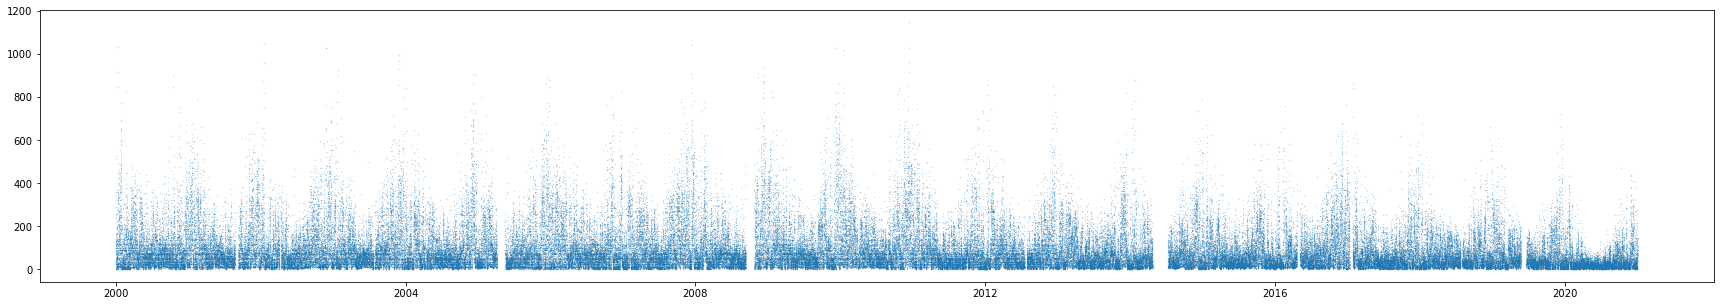

In [4]:
fig, axes = plt.subplots(1, figsize=(30,5))
axes.scatter(airPollutionTargetVector["Timestamp"], airPollutionTargetVector["nox"], s=0.01)

In [5]:
#However as there is a considerable amount of data avaliable, this is going to be reduced to just 2018.
airPollutionTargetVector["Year"] = airPollutionTargetVector["Timestamp"].dt.year
airPollutionTargetVector_2018 = airPollutionTargetVector[airPollutionTargetVector["Year"] == 2018]
airPollutionTargetVector_2018 = airPollutionTargetVector_2018.dropna()

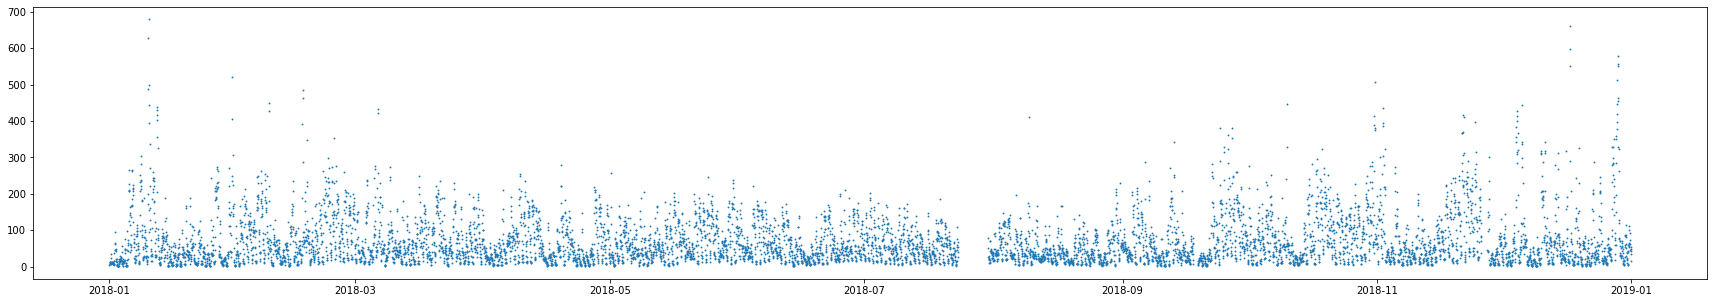

In [6]:
fig, axes = plt.subplots(1, figsize=(30,5))
axes.scatter(airPollutionTargetVector_2018["Timestamp"], airPollutionTargetVector_2018["nox"], s=0.75)

In [7]:
######
###### Stage 2: Summary Statistics of the data
######
######

airPollutionTargetVector_2018["nox"].describe()

count    8463.000000
mean       68.764461
std        67.502042
min         0.370770
25%        22.792370
50%        47.481180
75%        92.838905
max       679.416820
Name: nox, dtype: float64

In [8]:
######
###### Stage 3: Find the Timestamps that are missing. 
######
######
time_range = pd.DataFrame(pd.date_range('2018-01-01T00:00:00.000Z', '2018-12-12T23:00:00.000Z', freq='H')).rename(columns={0:"Timestamp"})
airPollutionTargetVector_2018_missingTimestamps = pd.merge(airPollutionTargetVector_2018, time_range, on="Timestamp", how="right")
airPollutionTargetVector_2018_missingTimestamps = airPollutionTargetVector_2018_missingTimestamps[airPollutionTargetVector_2018_missingTimestamps['nox'].isna()]
missingTimestamps = airPollutionTargetVector_2018_missingTimestamps[["Timestamp"]]
display(missingTimestamps)

,Timestamp
35,2018-01-02 11:00:00+00:00
250,2018-01-11 10:00:00+00:00
347,2018-01-15 11:00:00+00:00
706,2018-01-30 10:00:00+00:00
707,2018-01-30 11:00:00+00:00
...,...
7927,2018-11-27 07:00:00+00:00
7928,2018-11-27 08:00:00+00:00
7929,2018-11-27 09:00:00+00:00
7930,2018-11-27 10:00:00+00:00


In [9]:
#As we can see there are 297 values across the year that the monitoring stations broke down where we have no estimate for what the air pollution 
#like at the station 

#Therefore we are going to build a machine learning model that can learn a relationship and predict what the air pollution would look like in those
#timesteps.

In [10]:
######
###### Stage 4: Model with temporal variables 
######
######

In [11]:
#The first model that we can build could just look at the time of the day and make an estimate 

airPollutionTargetVector_2018["Hour"] = airPollutionTargetVector_2018["Timestamp"].dt.hour
airPollutionTargetVector_2018["Day"] = airPollutionTargetVector_2018["Timestamp"].dt.day
airPollutionTargetVector_2018["Week"] = airPollutionTargetVector_2018["Timestamp"].dt.isocalendar().week
airPollutionTargetVector_2018["Month"] = airPollutionTargetVector_2018["Timestamp"].dt.month
display(airPollutionTargetVector_2018)

,Timestamp,nox,Site Name,Site Code,Site Type,Year,Hour,Day,Week,Month
157800,2018-01-01 00:00:00+00:00,5.71130,Exeter Roadside,EX,Urban Traffic,2018,0,1,1,1
157801,2018-01-01 01:00:00+00:00,13.12678,Exeter Roadside,EX,Urban Traffic,2018,1,1,1,1
157802,2018-01-01 02:00:00+00:00,12.85043,Exeter Roadside,EX,Urban Traffic,2018,2,1,1,1
157803,2018-01-01 03:00:00+00:00,11.65290,Exeter Roadside,EX,Urban Traffic,2018,3,1,1,1
157804,2018-01-01 04:00:00+00:00,6.49430,Exeter Roadside,EX,Urban Traffic,2018,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...
166555,2018-12-31 19:00:00+00:00,49.68585,Exeter Roadside,EX,Urban Traffic,2018,19,31,1,12
166556,2018-12-31 20:00:00+00:00,42.86433,Exeter Roadside,EX,Urban Traffic,2018,20,31,1,12
166557,2018-12-31 21:00:00+00:00,54.76571,Exeter Roadside,EX,Urban Traffic,2018,21,31,1,12
166558,2018-12-31 22:00:00+00:00,33.38192,Exeter Roadside,EX,Urban Traffic,2018,22,31,1,12


In [12]:
#Linear Regression model 


#In this case we are going to make a linear regression model where the target variable is the nox concentrations at a given time
y = airPollutionTargetVector_2018["nox"].to_numpy()
#The feature vector, what we are going to try and predict the pollution 
X = airPollutionTargetVector_2018[["Hour", "Day", "Week", "Month"]].to_numpy()
reg = LinearRegression().fit(X, y)


display("The score of the model is: " + str(reg.score(X, y)))
display("The coefficient is: " + str(reg.coef_) + " The intercept was: " + str(reg.intercept_))


#The model predicts that on a monday at 8AM, in the third week of a January that the air pollution would be 53.67 ug/m^3
display("Example Predicition:" + str(reg.predict(np.array([[8, 1, 3, 1]]))))

'The score of the model is: 0.03340009808609756'

'The coefficient is: [ 1.55458864  0.46379169  0.94403671 -3.4584633 ] The intercept was: 41.39150381483532'

'Example Predicition:[53.66565146]'

In [13]:
#However as we can see the score for the other predicitions isnt great, we only achieve a score of 0.03
#As we know that air pollution can be affected by a range of different conditions, such as the wind speed, traffic, land use, we want to include those
#in our models 

In [14]:
######
###### Stage 5: Read in additional data 
######
######

airPollutionFeatureVector = pd.read_feather("AllDataset/airPollutionFeatureVector/Grid_173560.feather")
airPollutionFeatureVector["Timestamp"] = pd.to_datetime(airPollutionFeatureVector["Timestamp"], utc=True)
display(airPollutionFeatureVector)

,Grid ID,S5P_NO2,S5P_AAI,S5P_CO,S5P_HCHO,S5P_O3,Improved Grassland,Broadleaved woodland,Suburban,Arable and Horticulture,...,Point Source Score PI PM2.5,Point Source Score PI NMVOCs,Point Source Score PI Methane,Point Source Score PI SO2,Point Source Score PI All Pollutants,Month Number,Week Number,Day of Week Number,Hour Number,Timestamp
0,173560,0.000026,-0.673612,0.034357,-0.000011,0.143547,0.0,0.0,214.0,0.0,...,14.462116,73.941170,705.571434,483.658511,391699.603651,1,1,2,0,2014-01-01 00:00:00+00:00
1,173560,0.000026,-0.673612,0.034357,-0.000011,0.143547,0.0,0.0,214.0,0.0,...,14.462116,73.941170,705.571434,483.658511,391699.603651,1,1,2,1,2014-01-01 01:00:00+00:00
2,173560,0.000026,-0.673612,0.034357,-0.000011,0.143547,0.0,0.0,214.0,0.0,...,14.462116,73.941170,705.571434,483.658511,391699.603651,1,1,2,2,2014-01-01 02:00:00+00:00
3,173560,0.000026,-0.673612,0.034357,-0.000011,0.143547,0.0,0.0,214.0,0.0,...,14.462116,73.941170,705.571434,483.658511,391699.603651,1,1,2,3,2014-01-01 03:00:00+00:00
4,173560,0.000026,-0.673612,0.034357,-0.000011,0.143547,0.0,0.0,214.0,0.0,...,14.462116,73.941170,705.571434,483.658511,391699.603651,1,1,2,4,2014-01-01 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,173560,0.000015,-0.498857,0.031780,0.000106,0.137329,0.0,14.0,135.0,0.0,...,6.216449,67.978583,467.409296,326.642920,318688.885323,12,1,0,19,2018-12-31 19:00:00+00:00
43820,173560,0.000015,-0.498857,0.031780,0.000106,0.137329,0.0,14.0,135.0,0.0,...,6.216449,67.978583,467.409296,326.642920,318688.885323,12,1,0,20,2018-12-31 20:00:00+00:00
43821,173560,0.000015,-0.498857,0.031780,0.000106,0.137329,0.0,14.0,135.0,0.0,...,6.216449,67.978583,467.409296,326.642920,318688.885323,12,1,0,21,2018-12-31 21:00:00+00:00
43822,173560,0.000015,-0.498857,0.031780,0.000106,0.137329,0.0,14.0,135.0,0.0,...,6.216449,67.978583,467.409296,326.642920,318688.885323,12,1,0,22,2018-12-31 22:00:00+00:00


In [15]:
#We want to combine all the data into a single dataframe to make it easier to use 
airPollutionData = pd.merge(airPollutionTargetVector_2018, airPollutionFeatureVector, on="Timestamp")
display(airPollutionData)

,Timestamp,nox,Site Name,Site Code,Site Type,Year,Hour,Day,Week,Month,...,Point Source Score PI PM10,Point Source Score PI PM2.5,Point Source Score PI NMVOCs,Point Source Score PI Methane,Point Source Score PI SO2,Point Source Score PI All Pollutants,Month Number,Week Number,Day of Week Number,Hour Number
0,2018-01-01 00:00:00+00:00,5.71130,Exeter Roadside,EX,Urban Traffic,2018,0,1,1,1,...,34.186025,6.216449,67.978583,467.409296,326.64292,318688.885323,1,1,0,0
1,2018-01-01 01:00:00+00:00,13.12678,Exeter Roadside,EX,Urban Traffic,2018,1,1,1,1,...,34.186025,6.216449,67.978583,467.409296,326.64292,318688.885323,1,1,0,1
2,2018-01-01 02:00:00+00:00,12.85043,Exeter Roadside,EX,Urban Traffic,2018,2,1,1,1,...,34.186025,6.216449,67.978583,467.409296,326.64292,318688.885323,1,1,0,2
3,2018-01-01 03:00:00+00:00,11.65290,Exeter Roadside,EX,Urban Traffic,2018,3,1,1,1,...,34.186025,6.216449,67.978583,467.409296,326.64292,318688.885323,1,1,0,3
4,2018-01-01 04:00:00+00:00,6.49430,Exeter Roadside,EX,Urban Traffic,2018,4,1,1,1,...,34.186025,6.216449,67.978583,467.409296,326.64292,318688.885323,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8458,2018-12-31 19:00:00+00:00,49.68585,Exeter Roadside,EX,Urban Traffic,2018,19,31,1,12,...,34.186025,6.216449,67.978583,467.409296,326.64292,318688.885323,12,1,0,19
8459,2018-12-31 20:00:00+00:00,42.86433,Exeter Roadside,EX,Urban Traffic,2018,20,31,1,12,...,34.186025,6.216449,67.978583,467.409296,326.64292,318688.885323,12,1,0,20
8460,2018-12-31 21:00:00+00:00,54.76571,Exeter Roadside,EX,Urban Traffic,2018,21,31,1,12,...,34.186025,6.216449,67.978583,467.409296,326.64292,318688.885323,12,1,0,21
8461,2018-12-31 22:00:00+00:00,33.38192,Exeter Roadside,EX,Urban Traffic,2018,22,31,1,12,...,34.186025,6.216449,67.978583,467.409296,326.64292,318688.885323,12,1,0,22


In [16]:
######
###### Stage 6: Using Traffic Data 
######
######

In [17]:
#In this case we are going to make a linear regression model where the target variable is the nox concentrations at a given time
y = airPollutionData["nox"].to_numpy()
#The feature vector, what we are going to try and predict the pollution 
X = airPollutionData[["Hour", "Day", "Week", "Month", "HGV Score", "LGV Score", "Bicycle Score", "Bus and Coach Score", "Car and Taxi Score"]].to_numpy()
reg = LinearRegression().fit(X, y)

display("The score of the model is: " + str(reg.score(X, y)))
#this time when we include additional data from the traffic aspects our performance improves to 0.2! 

'The score of the model is: 0.20063314342666227'

In [18]:
######
###### Stage 7: Using Met Data
######
######

In [19]:
#What if we added in met data, such as the wind speed?

y = airPollutionData["nox"].to_numpy()
#The feature vector, what we are going to try and predict the pollution 
X = airPollutionData[["Hour", "Day", "Week", "Month", "HGV Score", "LGV Score", "Bicycle Score", "Bus and Coach Score", "Car and Taxi Score",
                     '100m_u_component_of_wind',
 '100m_v_component_of_wind',
 '10m_u_component_of_wind',
 '10m_v_component_of_wind',
 '2m_dewpoint_temperature',
 '2m_temperature',
 'instantaneous_10m_wind_gust',
 'surface_pressure',
 'total_column_rain_water',]].to_numpy()
reg = LinearRegression().fit(X, y)

display("The score of the model is: " + str(reg.score(X, y)))

'The score of the model is: 0.45677549192579536'

In [20]:
#This time our performance has increased to 0.45!

######
###### Stage 8: Fill in missing data
######
######


#Lets now try and fill in the missing values that we dont have an air pollution measurement for
time_range = pd.DataFrame(pd.date_range('2018-01-01T00:00:00.000Z', '2018-12-12T23:00:00.000Z', freq='H')).rename(columns={0:"Timestamp"})
airPollutionTargetVector_2018_missingTimestamps = pd.merge(airPollutionTargetVector_2018, time_range, on="Timestamp", how="right")
airPollutionTargetVector_2018_missingTimestamps = airPollutionTargetVector_2018_missingTimestamps[airPollutionTargetVector_2018_missingTimestamps['nox'].isna()]
#airPollutionTargetVector_2018_missingTimestamps = airPollutionTargetVector_2018_missingTimestamps[airPollutionTargetVector_2018_missingTimestamps["Year"] == 2018]
missingTimestamps = airPollutionTargetVector_2018_missingTimestamps[["Timestamp"]]
display(missingTimestamps)


,Timestamp
35,2018-01-02 11:00:00+00:00
250,2018-01-11 10:00:00+00:00
347,2018-01-15 11:00:00+00:00
706,2018-01-30 10:00:00+00:00
707,2018-01-30 11:00:00+00:00
...,...
7927,2018-11-27 07:00:00+00:00
7928,2018-11-27 08:00:00+00:00
7929,2018-11-27 09:00:00+00:00
7930,2018-11-27 10:00:00+00:00


In [21]:
missingTimestampsFeatureVectors = airPollutionFeatureVector[airPollutionFeatureVector["Timestamp"].isin(missingTimestamps["Timestamp"].tolist())].copy(deep=True)

In [22]:
missingTimestampsFeatureVectors["Hour"] = missingTimestampsFeatureVectors["Timestamp"].dt.hour
missingTimestampsFeatureVectors["Day"] = missingTimestampsFeatureVectors["Timestamp"].dt.day
missingTimestampsFeatureVectors["Week"] = missingTimestampsFeatureVectors["Timestamp"].dt.isocalendar().week
missingTimestampsFeatureVectors["Month"] = missingTimestampsFeatureVectors["Timestamp"].dt.month

In [23]:
X = missingTimestampsFeatureVectors[["Hour", "Day", "Week", "Month", "HGV Score", "LGV Score", "Bicycle Score", "Bus and Coach Score", "Car and Taxi Score",
                     '100m_u_component_of_wind',
 '100m_v_component_of_wind',
 '10m_u_component_of_wind',
 '10m_v_component_of_wind',
 '2m_dewpoint_temperature',
 '2m_temperature',
 'instantaneous_10m_wind_gust',
 'surface_pressure',
 'total_column_rain_water',]].to_numpy()
missingAirPollutionPredicitions = reg.predict(X)
display(X.shape)
display(missingAirPollutionPredicitions.shape)
display(missingTimestamps.shape)
missingTimestamps["nox Predictions"] = missingAirPollutionPredicitions
display(missingTimestamps)

(295, 18)

(295,)

(295, 1)

<ipython-input-23-36f6a63fb837>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missingTimestamps["nox Predictions"] = missingAirPollutionPredicitions


,Timestamp,nox Predictions
35,2018-01-02 11:00:00+00:00,42.114818
250,2018-01-11 10:00:00+00:00,123.146557
347,2018-01-15 11:00:00+00:00,3.191376
706,2018-01-30 10:00:00+00:00,156.246545
707,2018-01-30 11:00:00+00:00,136.173725
...,...,...
7927,2018-11-27 07:00:00+00:00,110.829753
7928,2018-11-27 08:00:00+00:00,123.877769
7929,2018-11-27 09:00:00+00:00,96.763790
7930,2018-11-27 10:00:00+00:00,64.239200


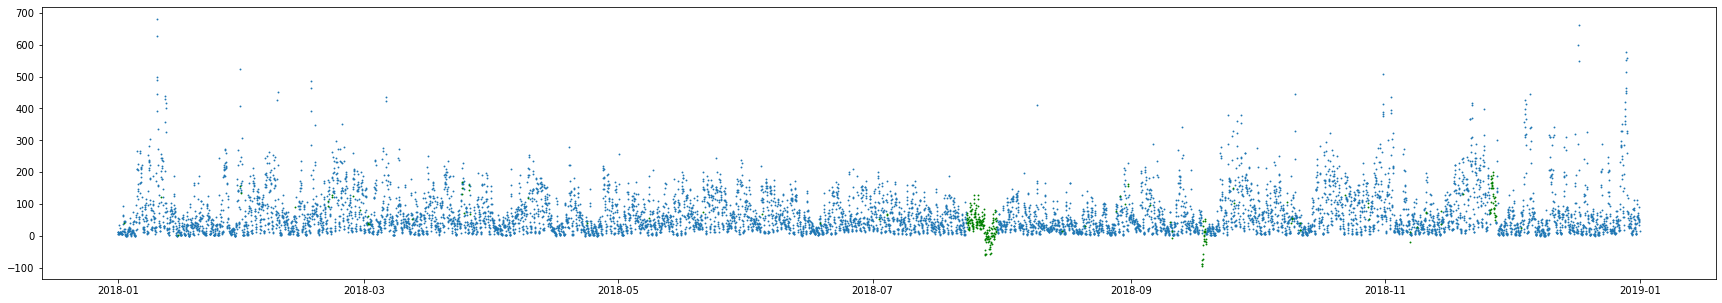

In [24]:
fig, axes = plt.subplots(1, figsize=(30,5))
airPollutionTargetVector_2018 = airPollutionTargetVector[airPollutionTargetVector["Year"] == 2018]
axes.scatter(airPollutionTargetVector_2018["Timestamp"], airPollutionTargetVector_2018["nox"], s=0.75)
axes.scatter(missingTimestamps["Timestamp"], missingTimestamps["nox Predictions"], color="green", s=0.75)

In [25]:
######
###### Stage 9: What are some issues with the process that has been shown so far?
######
######

In [26]:
#Some questions you may want to think about:
#Is the data being used to calculate the score fair?
#How could we deal with the negative predictions that are beinng made?
#How could we use train and test splitting?
#When would we want to use a validation set?

In [27]:
#However this is for data that the model has already seen, it was trained on this data.
#To get a fair representation of the model performance we want to test it on data 


######
###### Stage 10: Creating a Train, and Test Set
######
######
airPollutionDataTrainingData = airPollutionData[airPollutionData["Timestamp"] < '2018-9-1']
display(airPollutionDataTrainingData.shape)
airPollutionDataTestData = airPollutionData[airPollutionData["Timestamp"] >= '2018-9-1']
display(airPollutionDataTestData.shape)
display(airPollutionData.shape)

(5621, 112)

(2842, 112)

(8463, 112)

In [28]:
## Your code here to use the train and test split, investigate further the true performance of the model!

INFO: Successfully saved requirements file in ./requirements.txt
